In [81]:
EXP_DIR = 'exp_2'         # Directory of the experiment containing the trained neural network to use
N_TRIALS = 20             # Number of MCA trials to perform
MCA_TAG = 'python-numpy'  # Tag of the fuzzy docker image to use (python, python-numpy, etc.). It corresponds to the use of MCA in different parts of the stack
PRECISION_64 = 41         # Default: 53
PRECISION_32 = 18         # Default: 24

In [ ]:
import subprocess
from tqdm import tqdm
from utils import ExperimentResults


def get_vfc_backends(precision_64, precision_32):
    return ('libinterflop_mca.so '
            f'--precision-binary64={precision_64} '
            f'--precision-binary32={precision_32}')


def get_results_names(exp, mca_tag, vfc_backends):
    return exp.list(f"test_predictions_{MCA_TAG}-{vfc_backends.replace(' ', '_')}*")


exp = ExperimentResults(EXP_DIR)
vfc_backends = get_vfc_backends(PRECISION_64, PRECISION_32)

n_existing_trials = len(get_results_names(exp, MCA_TAG, vfc_backends))
for _ in tqdm(range(N_TRIALS - n_existing_trials)):
    subprocess.run(['./predict_with_mca.sh', EXP_DIR, MCA_TAG, vfc_backends],
                   check=True)

In [69]:
import numpy as np


def get_significant_digits(exp_dir=EXP_DIR, mca_tag=MCA_TAG,
                           precision_64=PRECISION_64, precision_32=PRECISION_32):
    """
        Using (3) from https://arxiv.org/pdf/1509.01347.pdf:
        Adding 1e-16 inside log10 to result in 16 significant digits (maximum
        with float64) when predictions_stds is 0.
    """
    exp = ExperimentResults(exp_dir)
    vfc_backends = get_vfc_backends(precision_64, precision_32)
    results_names = get_results_names(exp, mca_tag, vfc_backends)
    assert len(results_names) > 0, "No experiment results found"
    predictions_results = np.stack([exp.load(n) for n in results_names])
    print(f'Using data from {predictions_results.shape[0]} Monte-Carlo trials')

    predictions_means = predictions_results.mean(axis=0)
    predictions_stds = predictions_results.std(axis=0)
    return -np.log10(predictions_stds / (np.abs(predictions_means)) + 1e-16)

Using directory exp_2
Using data from 21 Monte-Carlo trials


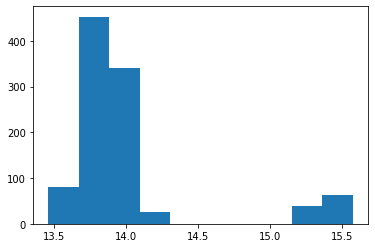

In [70]:
import matplotlib.pyplot as plt

significant_digits_base10 = get_significant_digits(precision_64=53, precision_32=24)
significant_digits_base10.round().astype(int)[:5]
plt.hist(significant_digits_base10.ravel());

Using directory exp_2
Using data from 20 Monte-Carlo trials


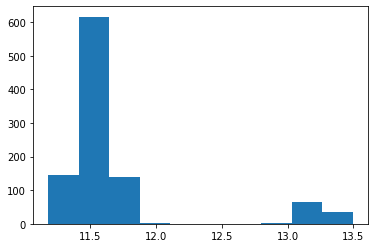

In [76]:
import matplotlib.pyplot as plt

significant_digits_base10 = get_significant_digits(precision_64=45, precision_32=20)
significant_digits_base10.round().astype(int)[:5]
plt.hist(significant_digits_base10.ravel());